# Enniscorthy EURO-CORDEX data

Enniscorthy is in Co. Wexford (-6.75, 52.75)

In [1]:
# set working directory to root
setwd("../../")

In [2]:
# import requirements and functions
source(
    "./jupyter-notebooks/scripts/spi-spei.R",
    echo = TRUE,
    max.deparse.length = 2000
)
library(sf)


> library(eurocordexr)


Loading required package: data.table

Loading required package: magrittr

Loading required package: ncdf4

Loading required package: ncdf4.helpers




> library(SPEI)


Loading required package: lmomco

Loading required package: parallel

Loading required package: ggplot2

# Package SPEI (1.7) loaded [try SPEINews()].




> library(latticeExtra)


Loading required package: lattice


Attaching package: ‘latticeExtra’


The following object is masked from ‘package:ggplot2’:

    layer





> library(lubridate)



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union





> kelvin_to_celsius <- function(kelvin) {
+     celsius <- (kelvin - 273.15)
+     return(celsius)
+ }

> kgm2s_to_mmday <- function(kgm2s) {
+     mmday <- (kgm2s * 60 * 60 * 24)
+     return(mmday)
+ }

> ec_process <- function(datapath, indexcell, var) {
+     df <- nc_grid_to_dt(filename = datapath, variable = var)
+     df <- subset(df, icell == indexcell)
+     df$date <- as.Date(df$date, format = "%Y-%m-%d")
+     df$month <- month(df$date, label = TRUE)
+     df$year <- year(df$date)
+     if (var == "pr") {
+         df$pr <- kgm2s_to_mmday(df$pr)
+     }
+     else if (var == "tasmax") {
+         df$tasmax <- kelvin_to_celsius(df$tasmax)
+     }
+     else if (var == "tasmin") {
+         df$tasmin <- kelvin_to_celsius(df$tasmin)
+     }
+     return(df)
+ }

> hist_process <- function(datadir, variable, indexcell) {
+     ncfile <- paste(datadir, variable, "_EUR-11_NCC-NorESM1-M_historical_r1i1p1_DMI-HIRHAM5_v3_mon_", 
+         sep = "")
+     d1 <- ec_process(datapath = 

Linking to GEOS 3.10.2, GDAL 3.5.0, PROJ 9.0.0; sf_use_s2() is TRUE



In [5]:
# directory where the future nc files are stored
datadir <- "./data/eurocordex/DMI/rcp85/mon/"

## Finding the closest grid cell

In [6]:
# read one of the EURO-CORDEX data files
ncfile <- paste(
    datadir,
    "pr_EUR-11_NCC-NorESM1-M_rcp85_r1i1p1_DMI-HIRHAM5_v3_mon_204101-205012.nc",
    sep = ""
)

In [7]:
# extract the latitude and longitude from the nc file
df_coord <- nc_grid_to_dt(filename = ncfile, variable = "lat")
df_coord$lon <- nc_grid_to_dt(filename = ncfile, variable = "lon")$lon

In [8]:
head(df_coord)

icell,date,lat,lon
<int>,<lgl>,<dbl>,<dbl>
174265,NA,21.98783,-10.063880
174266,NA,22.02784,-9.963886
174267,NA,22.06772,-9.863804
174268,NA,22.10746,-9.763632
174269,NA,22.14708,-9.663371
174270,NA,22.18656,-9.563022


In [9]:
# sort by grid cell in ascending order
df_coord <- df_coord[order(df_coord$icell),]

In [10]:
# remove redundant date column
df_coord$date <- NULL

In [11]:
head(df_coord)

icell,lat,lon
<int>,<dbl>,<dbl>
1,60.20376,-44.59386
2,60.27934,-44.45553
3,60.35482,-44.31666
4,60.43020,-44.17726
5,60.50549,-44.03732
6,60.58068,-43.89684


In [12]:
# create a row corresponding to Enniscorthy's coordinates at icell = -1
df_coord <- rbind(data.frame(
    icell = -1, lon = -6.75, lat = 52.75
), df_coord)

In [13]:
head(df_coord, 10)

,icell,lon,lat
,<dbl>,<dbl>,<dbl>
1,-1,-6.75000,52.75000
2,1,-44.59386,60.20376
3,2,-44.45553,60.27934
4,3,-44.31666,60.35482
5,4,-44.17726,60.43020
6,5,-44.03732,60.50549
7,6,-43.89684,60.58068
8,7,-43.75581,60.65577
9,8,-43.61423,60.73076


In [14]:
# convert to a spatial data frame
df_coord_sf <- st_as_sf(df_coord, coords = c("lon", "lat"), crs = 4326)

In [15]:
# create a standalone data frame for the Enniscorthy data
study <- subset(df_coord_sf, icell == -1)

In [16]:
# calculate the distance between Enniscorthy and all other cells
df_coord_sf$dist <- st_distance(df_coord_sf, study)

In [17]:
# convert to data frame to view the results
df_coord_sf <- as.data.frame(df_coord_sf)

In [18]:
# sort by distance in ascending order
df_coord_sf <- df_coord_sf[order(df_coord_sf$dist),]

In [19]:
# reset row names
rownames(df_coord_sf) <- NULL

In [20]:
# view the results
head(df_coord_sf, 10)

,icell,geometry,dist
,<dbl>,<POINT [°]>,<[m]>
1,-1,POINT (-6.75 52.75),0.000
2,67117,POINT (-6.756396 52.73166),2084.813
3,66693,POINT (-6.815624 52.83566),10497.298
4,67118,POINT (-6.585004 52.76721),11266.703
5,67116,POINT (-6.927517 52.69587),13385.018
6,67541,POINT (-6.697451 52.62762),14061.346
7,66694,POINT (-6.643896 52.8713),15256.834
8,66692,POINT (-6.987079 52.79979),16881.422
9,67542,POINT (-6.526394 52.6631),17897.750


In [21]:
# save closest grid cell value
icell_ <- df_coord_sf[2, "icell"]

In [22]:
icell_

[1] 67117

## Plots

In [23]:
# set plot resolution
options(repr.plot.res = 200)

In [24]:
# separate study area coordinates from the cells
study <- subset(df_coord, icell < 0)
df_coord <- subset(df_coord, icell > 0)

In [25]:
# filter closest cells
icell <- subset(df_coord, icell == icell_)

In [26]:
study

,icell,lon,lat
,<dbl>,<dbl>,<dbl>
1,-1,-6.75,52.75


In [27]:
head(df_coord)

,icell,lon,lat
,<dbl>,<dbl>,<dbl>
2,1,-44.59386,60.20376
3,2,-44.45553,60.27934
4,3,-44.31666,60.35482
5,4,-44.17726,60.43020
6,5,-44.03732,60.50549
7,6,-43.89684,60.58068


In [28]:
icell

,icell,lon,lat
,<dbl>,<dbl>,<dbl>
67118,67117,-6.756396,52.73166


In [29]:
# convert to spatial data frames
df_coord_sf <- st_as_sf(df_coord, coords = c("lon", "lat"), crs = 4326)
study <- st_as_sf(study, coords = c("lon", "lat"), crs = 4326)
icell <- st_as_sf(icell, coords = c("lon", "lat"), crs = 4326)

In [4]:
# Ireland boundary data
ie <- st_read("./data/boundary/boundaries.gpkg", "NUTS_Ireland")

Reading layer `NUTS_Ireland' from data source 
  `/run/media/nms/Backup/Documents/Git/ClimAg/ClimAg/data/boundary/boundaries.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -10.66164 ymin: 51.42259 xmax: -5.433173 ymax: 55.43512
Geodetic CRS:  WGS 84


In [31]:
print(ie)

Simple feature collection with 1 feature and 1 field
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -10.66164 ymin: 51.42259 xmax: -5.433173 ymax: 55.43512
Geodetic CRS:  WGS 84
     NAME                           geom
1 Ireland MULTIPOLYGON (((-10.19022 5...


In [32]:
# keep only cells that intersect with Ireland's boundary
df_coord_ie <- st_intersection(df_coord_sf, ie)

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [33]:
# project to Irish transverse mercator
# https://www.gov.uk/government/publications/uk-geospatial-data-standards-register/national-geospatial-data-standards-register#standards-for-coordinate-reference-systems
crs_ie <- 2157

df_coord_ie = st_transform(df_coord_ie, crs = crs_ie)
ie = st_transform(ie, crs = crs_ie)
study = st_transform(study, crs = crs_ie)
icell = st_transform(icell, crs = crs_ie)

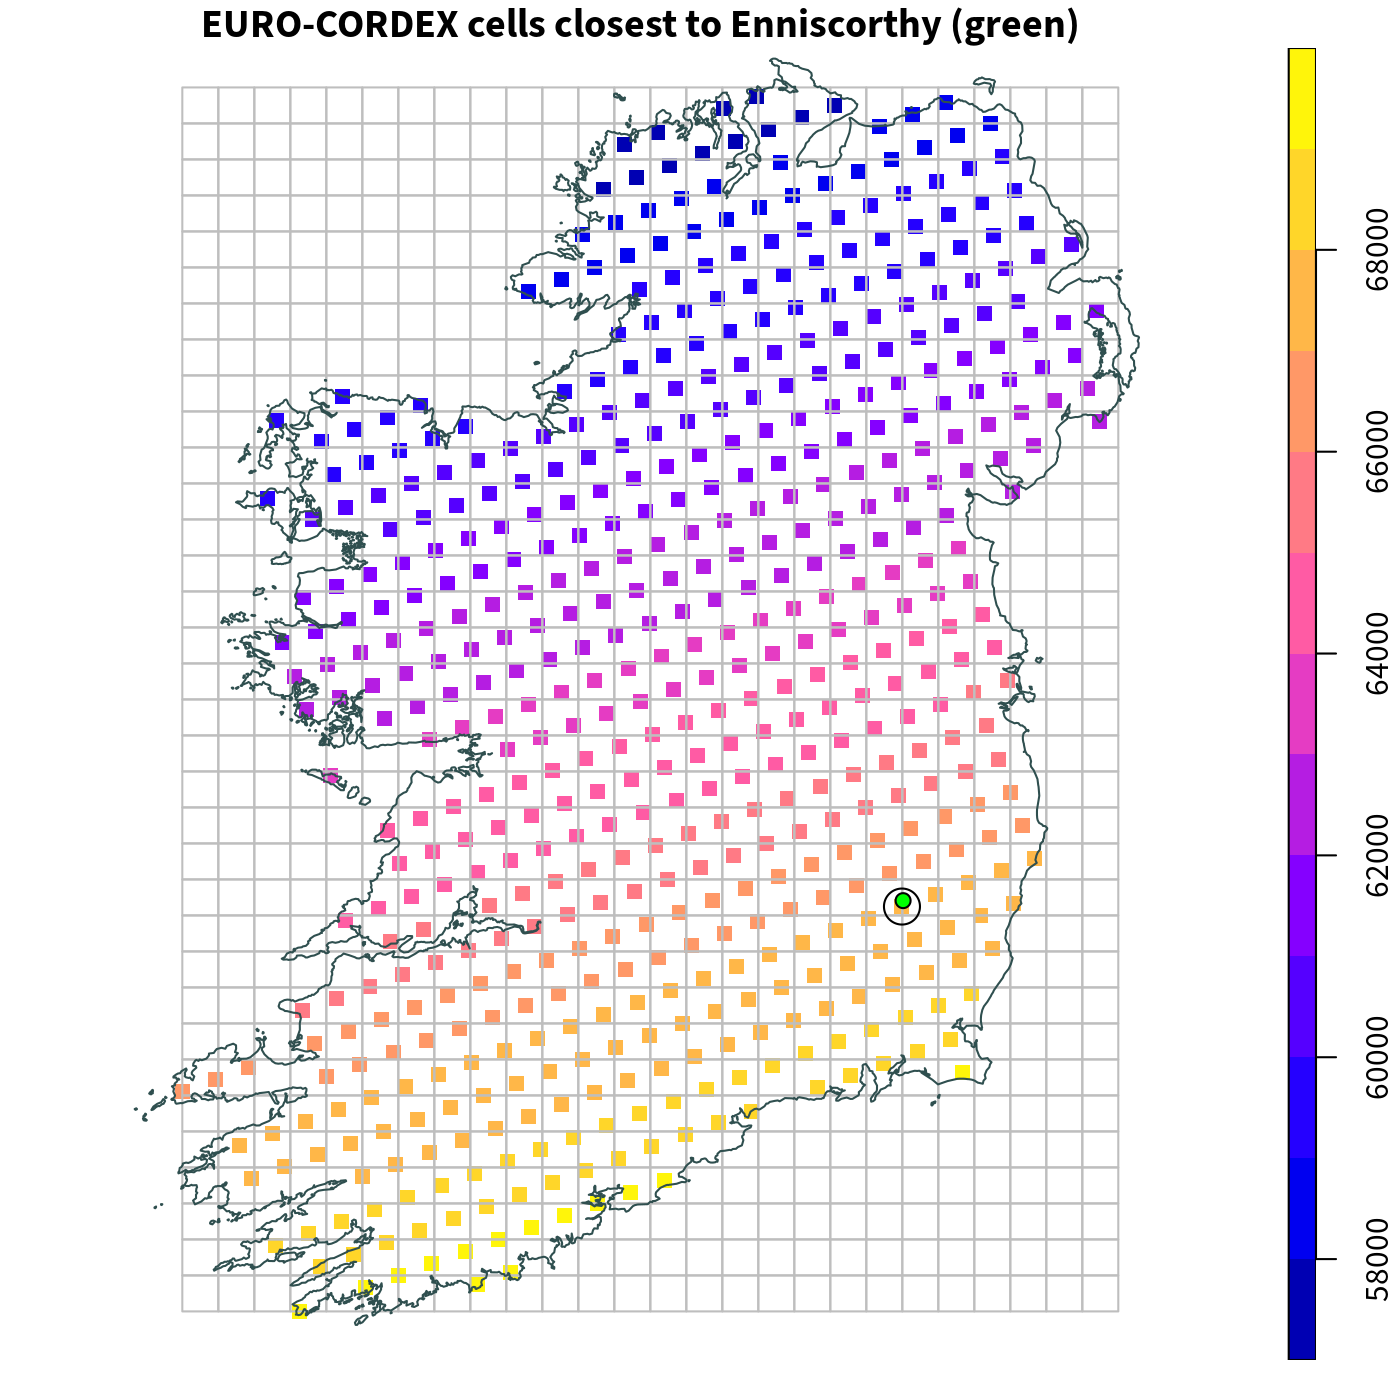

In [34]:
par(family = "Source Sans 3")

plot(
    df_coord_ie["icell"],
    pch = 15,
    main = "EURO-CORDEX cells closest to Enniscorthy (green)",
    key.length = 1,
    key.width = lcm(1.5),
    # axes = TRUE,
    reset = FALSE
)
plot(
    st_make_grid(df_coord_ie, cellsize = 12500),
    border = "grey",
    add = TRUE
)
plot(st_boundary(st_buffer(icell, dist = 12500/2)), col = "black", add = TRUE)
plot(study["geometry"], pch = 21, bg = c("green"), add = TRUE)
plot(ie["geom"], add = TRUE, border = "darkslategrey")

## Extracting RCP8.5 precipitation data

In [35]:
# process precipitation data
pr <- future_process(
    datadir = datadir, variable = "pr", indexcell = icell_
)

In [36]:
head(pr)

pr,month,year
<dbl>,<ord>,<dbl>
5.285282,Jan,2041
3.075893,Feb,2041
5.122228,Mar,2041
4.561719,Apr,2041
2.194052,May,2041
3.153906,Jun,2041


In [37]:
dcast(pr, year~month, value.var = c("pr"))

year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2041,5.285282,3.075893,5.122228,4.5617187,2.1940524,3.1539063,0.6764113,4.0057964,2.061198,5.011089,2.508594,4.840978
2042,5.232107,4.808873,4.855343,2.1265626,2.1474294,2.8375000,1.6103831,1.9208669,2.885417,3.619960,3.937500,2.817792
2043,2.548891,5.902902,4.721018,0.9419271,2.3649194,3.3455728,2.3452621,3.2041329,1.323438,3.693548,5.080990,4.956149
2044,3.129032,3.418248,4.028478,2.0473957,2.5730847,2.8255209,3.4858872,1.7154738,2.272917,2.841986,3.440625,4.534778
2045,3.611643,3.239676,4.978831,2.5945312,1.1209678,2.4630208,1.1028226,1.7641130,2.600260,3.548135,4.289844,4.315020
2046,4.064264,4.981027,2.785030,1.1742187,0.8162803,2.9289062,2.3634072,1.2074093,1.060937,3.396169,5.959375,4.508065
2047,4.704385,2.039062,3.405998,1.8835937,3.4873990,2.5083334,3.0171372,0.7192540,2.753125,5.356603,4.139063,4.277218
2048,3.727823,3.888114,5.183972,2.6367188,3.4458165,3.1835939,1.2167339,2.5012601,3.716146,4.218498,3.634115,3.973286
2049,2.484123,4.467355,3.994708,3.2684896,2.3422378,3.6091147,1.6837198,1.4276714,3.903646,6.853327,4.150260,4.510332


In [39]:
# save as CSV file
write.table(
    pr,
    file = paste(
        "./data/eurocordex/DMI/",
        "enniscorthy_pr_EUR-11_",
        "NCC-NorESM1-M_rcp85_r1i1p1_DMI-HIRHAM5_v3_mon.csv",
        sep = ""
    ),
    row.names = FALSE,
    sep = ",",
    quote = FALSE
)

## Extracting historic data

In [8]:
# directory where the historical nc files are stored
datadir <- "./data/eurocordex/DMI/historical/mon/"

In [11]:
# process precipitation data
pr <- hist_process(
    datadir = datadir, variable = "pr", indexcell = icell_
)

In [12]:
head(pr)

pr,month,year
<dbl>,<ord>,<dbl>
5.196572,Jan,1976
3.957868,Feb,1976
5.010081,Mar,1976
3.180729,Apr,1976
3.570313,May,1976
2.273177,Jun,1976


In [13]:
dcast(pr, year~month, value.var = c("pr"))

year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1976,5.196572,3.957868,5.010081,3.180729,3.5703126,2.2731770,3.1673388,6.212449,3.2531250,2.840474,4.280729,4.682712
1977,5.743447,2.991071,4.290575,4.630989,2.5156250,3.2002605,4.2220262,2.322329,2.5494792,2.242692,2.454167,4.326361
1978,3.284778,2.607701,3.490927,4.452864,1.5209173,3.3786457,2.9014616,2.840726,1.8432292,3.543347,4.990104,3.730595
1979,4.587450,3.572545,2.379536,2.663021,0.4926915,3.0145833,3.6030747,1.300403,3.7473959,3.735131,3.407813,3.944052
1980,2.941784,3.616350,2.424143,7.288542,3.7207663,1.9028646,2.0378025,2.439516,2.9390626,3.565776,4.065365,5.615675
1981,5.720514,3.934152,4.557964,3.651823,4.6113912,2.3955730,2.4082661,2.832661,4.2286458,2.984627,4.736979,3.759324
1982,3.833165,3.219866,3.181452,3.309115,2.4443044,1.6554687,3.2870465,1.763105,5.1661458,2.564012,3.906510,2.913306
1983,3.255040,4.637556,3.200353,4.172917,0.9226311,1.5606771,0.8495464,3.291079,3.8369791,3.845010,3.917708,2.326613
1984,3.360635,3.551339,3.534274,3.244531,1.3177923,2.4598958,2.7809979,3.293599,3.4760417,4.649445,6.195573,3.875504


In [14]:
# save as CSV file
write.table(
    pr,
    file = paste(
        "./data/eurocordex/DMI/",
        "enniscorthy_pr_EUR-11_",
        "NCC-NorESM1-M_historical_r1i1p1_DMI-HIRHAM5_v3_mon.csv",
        sep = ""
    ),
    row.names = FALSE,
    sep = ",",
    quote = FALSE
)